# IMPORT

In [1]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

# Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import gdown
#from datasets import Dataset, DatasetDict

import os
import io
import traceback
from datetime import datetime

import json

# Our file
from training.train import train

try:
    import google.colab
    colab = True
except:
    colab = False
    
pd.set_option('display.max_columns', None)


**Reproducibility and Device Setting**

In [2]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
#random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [3]:
def normalize_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Normalizes the specified columns in the DataFrame between 0 and 1.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    columns (list): A list of column names to normalize.

    Returns:
    pd.DataFrame: A new DataFrame with the specified columns normalized.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    for column in columns:
        if column in df_copy.columns:
            min_val = df_copy[column].min()
            max_val = df_copy[column].max()

            # Avoid division by zero if the column has a constant value
            if max_val != min_val:
                df_copy[column] = (df_copy[column] - min_val) / (max_val - min_val)
            else:
                # If the column has constant values, normalize to 0 (or 1, depends on the case)
                df_copy[column] = 0
        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")

    return df_copy


def merge_on_closest_time(df1, df2, time_col='time'):
    # Ensure the 'time' columns are datetime objects
    df1[time_col] = pd.to_datetime(df1[time_col])
    df2[time_col] = pd.to_datetime(df2[time_col])

    # Sort both dataframes by time (if not already sorted)
    df1 = df1.sort_values(by=time_col).reset_index(drop=True)
    df2 = df2.sort_values(by=time_col).reset_index(drop=True)

    # Create an empty list to hold the merged rows
    merged_rows = []

    # Initialize pointers for both DataFrames
    i, j = 0, 0

    # Iterate through each row in df1 and find the closest time in df2
    while i < len(df1):
        row1 = df1.iloc[i]

        # Move pointer j to the closest time in df2 (either before or after row1)
        while j < len(df2) - 1 and abs(df2.iloc[j + 1][time_col] - row1[time_col]) < abs(df2.iloc[j][time_col] - row1[time_col]):
            j += 1

        # Get the closest row from df2
        closest_row = df2.iloc[j]

        # Combine the row from df1 with the closest row from df2
        merged_row = pd.concat([row1, closest_row], axis=0)

        # Reset the index of the concatenated row before appending to avoid duplicate indices
        merged_rows.append(merged_row.reset_index(drop=True))

        # Move the pointer for df1
        i += 1

    # Create a new DataFrame from the merged rows and reset the index
    merged_df = pd.DataFrame(merged_rows)
    merged_df.reset_index(drop=True, inplace=True)

    return merged_df

def transform_dataframe(df):
    # Create an empty list to store the filled rows
    filled_rows = []

    # Iterate through each row in the DataFrame
    for i, row in df.iterrows():
        # If X1 is not NaN, we know this is a valid row for X1
        if pd.notna(row['X1']):
            x1_value = row['X1']
            filled_rows.append({'time': row['time'], 'X1': x1_value, 'Y1': df.iloc[i+1]['Y1'], 'Z1': df.iloc[i+2]['Z1']})

    # Convert the list of filled rows to a DataFrame
    filled_df = pd.DataFrame(filled_rows)

    # Now group the data by time and use the last available X1, Y1, and Z1 for each time
    final_df = filled_df.groupby('time').last().reset_index()

    return final_df

# DATASET

In [4]:
def download_csv(link_zipped_csv, gdrive_link, zipped_file):

    file_id = link_zipped_csv.split('/')[-2]  # Take the file_id (Ex. "https://drive.google.com/file/d/1BMj4BGXxIMzsd-GYSAEMpB7CF0XB87UT/view?usp=sharing" => file_id: 1BMj4BGXxIMzsd-GYSAEMpB7CF0XB87UT)
    download_link = gdrive_link + file_id # Create the path for gdown (Ex. https://drive.google.com/uc?id={YOUR_FILE_ID})

    try:
        if not os.path.exists(zipped_file):

            gdown.download(
                download_link,
                zipped_file,
                quiet=False
                )
        else:
            print("CSV file already downloaded!")


    except Exception as error:
        print("An error occured:", error)
        traceback.print_exc()

In [5]:
def unzip_csv(csv_zip, csv_dir):

    try:
        if not os.path.exists(csv_dir):
            os.mkdir(csv_dir) # Create the csv_dir directory where we extract files (if not exists)

        if len(os.listdir(csv_dir)) == 0:
            with zipfile.ZipFile(csv_zip, 'r') as zip:
                filelist = zip.namelist() # list of the file inside zip : ['csv /multilingual_nli_test_df.csv', 'csv /tweet_emotions.csv', ...]

                # Iterate over all file in the zip file to extract them
                for filename in filelist:
                    zip.extract(filename, csv_dir) # Extract the file inside the csv_dir

        else:
            print("CSV file already unzipped!")


    except Exception as error:
        print("An error occured:", error)
        traceback.print_exc()

In [6]:
link_zipped_csv = 'https://drive.google.com/file/d/1MssQF4pI_rZqiiDBP4XaLTT1ZaN6ykLm/view?usp=drive_link'
gdrive_link = 'https://drive.google.com/uc?id='
csv_dir = './csv'
zipped_file = './csv.zip'

download_csv(
    link_zipped_csv,
    gdrive_link,
    zipped_file
)

unzip_csv(
    zipped_file,
    csv_dir,
)


CSV file already downloaded!
CSV file already unzipped!


In [7]:
def load_dataset_dict_pandas(csv_path):

    # Initialization of the dictionary of input data (text) {'filename': ['hi ...','I am ...']}
    text_dict = {}

    filelist = os.listdir(csv_path) # List of all csv file ['filename_1.csv', ...]

    # Iterate over all csv file in the directory
    for filename in filelist:
        # Initialization of the list containing all the texts in a csv file

        text_dict[filename] = []
        # Open the i-th csv file

        test = pd.read_csv(csv_path + '/' + filename)
        print(filename)
        print(test.info())


In [8]:
path = '/content/csv/thermal_drift_features_lab_05_02.csv'


if colab:
    prefix = '/content'
else:
    prefix = '.'


features = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_02.csv'))
features1 = pd.read_csv(os.path.join(prefix, 'csv/thermal_drift_features_lab_05_03.csv'))
features2 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_04.csv'))
features3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_05.csv'))
features4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_features_lab_05_06.csv'))

targets = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_02.csv'))
targets1 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_03.csv'))
targets2 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_04.csv'))
targets3 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_05.csv'))
targets4 = pd.read_csv(os.path.join(prefix,'csv/thermal_drift_targets_lab_05_06.csv'))


In [9]:
features = pd.concat([features,features1,features2,features3,features4])

features.drop([
    "name", "tags",
    "2\"Tray1 Vacuum Sensor", "2\"Tray2 Vacuum Sensor", "2\"Tray3 Vacuum Sensor",
    "Avg Oven Temperature", "Chuck Temp [Cdeg]", "Chuck Temp2 [Cdeg]",
    "Chuck1 Vacuum Sensor", "Contrast", "Device State",
    "Dispenser1 Pressure Sensor", "Machine Room Temp", "Main Air", "Main Vacuum",
    "Oven Temperature", "PE_Rx", "PE_Ry", "PE_Rz", "PE_X1", "PE_Y1", "PE_Z1",
    "PUT1 Flow Sensor", "PUT2 Flow Sensor1", "PUT2 Flow Sensor2",
    "PUT2 Flow Sensor3", "PUT2 Flow Sensor4", "PUT2 Flow Sensor5",
    "Photodiode", "Pixel Power", "Preciser1 Vacuum Sensor",
    "Tec FIB1 Holder", "Tec FIB1 Plate", "Tec FIB2 Holder", "Tec FIB2 Plate",
    "Torque11","Torque2","Torque3","Torque4","Torque5","Torque6"
], axis=1, inplace=True)

In [10]:
targets_norm= normalize_columns(targets, ['X1','Y1','Z1'])
targets_norm1= normalize_columns(targets1, ['X1','Y1','Z1'])
targets_norm2= normalize_columns(targets2, ['X1','Y1','Z1'])
targets_norm3= normalize_columns(targets3, ['X1','Y1','Z1'])
targets_norm4= normalize_columns(targets4, ['X1','Y1','Z1'])

targets = pd.concat([targets,targets1,targets2,targets3,targets4])

In [11]:
features

,time,Temp Sensor 1,Temp Sensor 2,Temp Sensor 3,Temp Sensor 4
0,1714640400018369000,2137,2164,2163,2159
1,1714640400095369000,2137,2164,2163,2159
2,1714640400186397000,2137,2164,2163,2159
3,1714640400395459000,2136,2164,2163,2159
4,1714640400445367000,2136,2164,2163,2159
...,...,...,...,...,...
498320,1714981388043125000,2126,2167,2152,2150
498321,1714981388090182000,2126,2167,2152,2150
498322,1714981388133949000,2126,2167,2152,2150
498323,1714981388190053000,2126,2167,2153,2150


In [12]:
targets.head(10)

,name,tags,time,X1,Y1,Z1
0,process_parameters,NaN,1714640401106507000,-42506.390100,NaN,NaN
1,process_parameters,NaN,1714640401181516000,NaN,44830.277517,NaN
2,process_parameters,NaN,1714640401190109000,NaN,NaN,12931.601562
3,process_parameters,NaN,1714640412382008000,-42506.368407,NaN,NaN
4,process_parameters,NaN,1714640412388469000,NaN,44830.177972,NaN
5,process_parameters,NaN,1714640412396388000,NaN,NaN,12931.601562
6,process_parameters,NaN,1714640423632736000,-42506.327086,NaN,NaN
7,process_parameters,NaN,1714640423648225000,NaN,44830.179741,NaN
8,process_parameters,NaN,1714640423653739000,NaN,NaN,12931.523438
9,process_parameters,NaN,1714640434970393000,-42506.308733,NaN,NaN


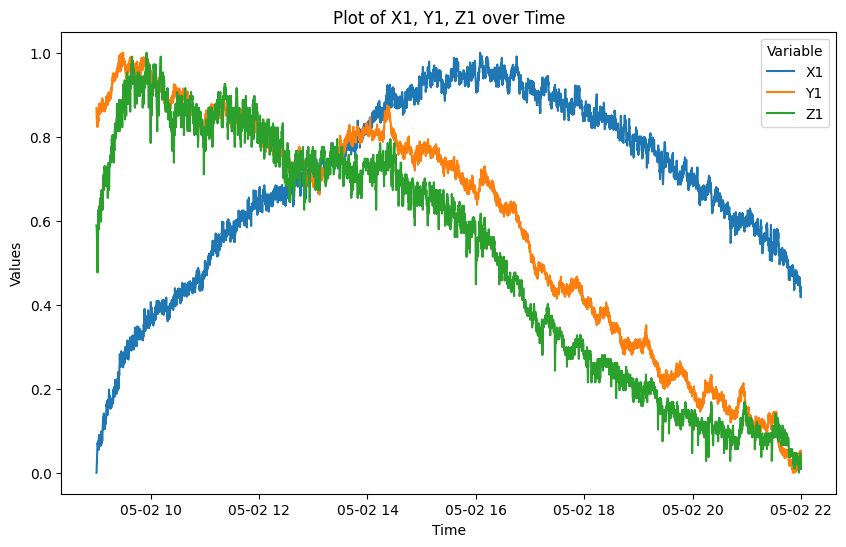

In [13]:
targets_norm['time'] = pd.to_datetime(targets_norm['time'], unit='ns')

# Reshape the DataFrame using melt()
targets_melted = targets_norm.reset_index().melt(id_vars=['time'], value_vars=['X1', 'Y1', 'Z1'], var_name='variable', value_name='value')

# Drop rows where 'value' is NaN (to keep only the non-null entries)
targets_melted = targets_melted.dropna(subset=['value'])

# Plot the data
plt.figure(figsize=(10, 6))
for var in targets_melted['variable'].unique():
    # Filter data for each variable and plot
    temp_df = targets_melted[targets_melted['variable'] == var]
    plt.plot(temp_df['time'], temp_df['value'], label=var)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of X1, Y1, Z1 over Time')
plt.legend(title='Variable')

# Show the plot
plt.show()

#targets.plot(y='X1',x='time')

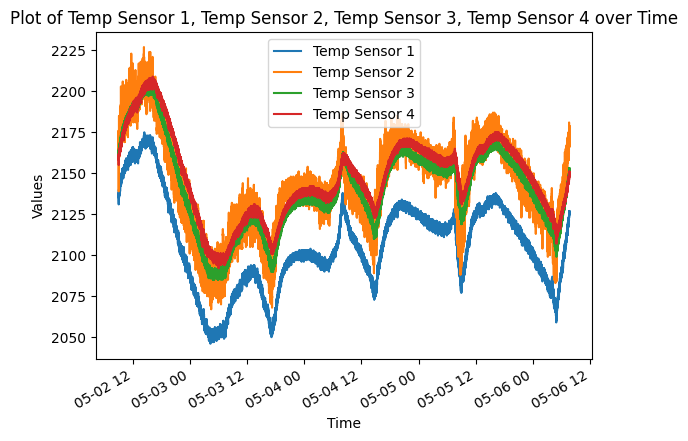

In [14]:
# Convert 'time' to datetime (nanoseconds to datetime)
features['time'] = pd.to_datetime(features['time'], unit='ns')

# Set 'time' as the index
features.set_index('time', inplace=True)

# Optionally, you can plot X1, Y1, Z1 directly
features[['Temp Sensor 1', 'Temp Sensor 2', 'Temp Sensor 3', 'Temp Sensor 4', ]].plot()

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Plot of Temp Sensor 1, Temp Sensor 2, Temp Sensor 3, Temp Sensor 4 over Time')

# Show the plot
plt.show()

In [15]:
PE = False
if PE:
  # Optionally, you can plot X1, Y1, Z1 directly
  features[['PE_X1', 'PE_Y1']].plot()

  # Add labels and title
  plt.xlabel('Time')
  plt.ylabel('Values')
  plt.title('Plot of Temp Sensor 1, Temp Sensor 2, Temp Sensor 3, Temp Sensor 4 over Time')

  # Show the plot
  plt.show()

In [16]:
fixed_targets = transform_dataframe(targets)

In [17]:
fixed_targets

,time,X1,Y1,Z1
0,1714640401106507000,-42506.390100,44830.277517,12931.601562
1,1714640412382008000,-42506.368407,44830.177972,12931.601562
2,1714640423632736000,-42506.327086,44830.179741,12931.523438
3,1714640434970393000,-42506.308733,44830.136638,12931.445312
4,1714640446143996000,-42506.280652,44830.203599,12931.289062
...,...,...,...,...
30385,1714981121245682000,-42505.001668,44828.086368,12930.156250
30386,1714981132455133000,-42505.022450,44828.139340,12929.960938
30387,1714981143894547000,-42505.032772,44828.097332,12929.960938
30388,1714981155081468000,-42504.992528,44828.076567,12930.078125


In [18]:
complete_numbers = merge_on_closest_time(fixed_targets.reset_index(), features.reset_index())

In [19]:
complete = complete_numbers.rename(columns={
    0: 'id',
    1: 'time',
    2: 'X1',
    3: 'Y1',
    4: 'Z1',
    5: 'to_remove',
    6: 'Temp1',
    7: 'Temp2',
    8: 'Temp3',
    9: 'Temp4'
    })
complete.drop(['to_remove', 'time'], axis=1, inplace=True)

In [20]:
complete

,id,X1,Y1,Z1,Temp1,Temp2,Temp3,Temp4
0,0,-42506.390100,44830.277517,12931.601562,2136,2164,2163,2159
1,1,-42506.368407,44830.177972,12931.601562,2136,2170,2162,2160
2,2,-42506.327086,44830.179741,12931.523438,2136,2176,2163,2160
3,3,-42506.308733,44830.136638,12931.445312,2137,2161,2162,2159
4,4,-42506.280652,44830.203599,12931.289062,2134,2151,2163,2158
...,...,...,...,...,...,...,...,...
30385,30385,-42505.001668,44828.086368,12930.156250,2104,2137,2145,2157
30386,30386,-42505.022450,44828.139340,12929.960938,2104,2137,2145,2157
30387,30387,-42505.032772,44828.097332,12929.960938,2104,2137,2145,2157
30388,30388,-42504.992528,44828.076567,12930.078125,2104,2137,2145,2157


In [21]:
complete.astype(float)

X = complete[['Temp1','Temp2', 'Temp3', 'Temp4']]
Y = complete[['X1', 'Y1', 'Z1']]

Y = Y.values.astype(np.float32)
Y = np.gradient(Y, axis=0)
X = X.values.astype(np.float32)
X /= 100

In [22]:
print(X)
print(Y)

[[21.36 21.64 21.63 21.59]
 [21.36 21.7  21.62 21.6 ]
 [21.36 21.76 21.63 21.6 ]
 ...
 [21.04 21.37 21.45 21.57]
 [21.04 21.37 21.45 21.57]
 [21.04 21.37 21.45 21.57]]
[[ 0.0234375  -0.09765625  0.        ]
 [ 0.03125    -0.04882812 -0.0390625 ]
 [ 0.02929688 -0.02148438 -0.078125  ]
 ...
 [ 0.015625   -0.03125     0.05859375]
 [ 0.01171875 -0.02734375  0.05859375]
 [-0.015625   -0.03515625  0.        ]]


In [23]:
def split(listToSplit, splitPercentages):
  length = len(listToSplit)
  splittedList = []
  lastIndex = 0
  for percentageIndex in range(len(splitPercentages)):
    print(lastIndex)
    splittedList.append(listToSplit[lastIndex:lastIndex+int(splitPercentages[percentageIndex]*length)])
    lastIndex += int(splitPercentages[percentageIndex]*length)

  return splittedList

In [24]:
splitPerc = [0.7,0.2,0.1]
splitted_X = split(X, splitPerc)
splitted_Y = split(Y, splitPerc)

0
21273
27351
0
21273
27351


In [25]:
class thermal_dataset(Dataset):
  def __init__(self, data, lookback):
    super()
    X, y = [], []
    #print(data)
    #print(lookback)
    #print(len(data[0])-lookback)
    for i in range(len(data[0])-lookback):
      feature = data[0][i:i+lookback]
      target = data[1][i:i+lookback]
      X.append(feature)
      y.append(target)
    self.X = torch.tensor(np.array(X))
    self.y = torch.tensor(np.array(y))

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

In [26]:
datasetTrain = thermal_dataset((splitted_X[0],splitted_Y[0]), 5)
datasetTest = thermal_dataset((splitted_X[1],splitted_Y[1]), 5)
datasetVal = thermal_dataset((splitted_X[2],splitted_Y[2]), 5)

In [27]:
datasetTrain[-1]

(tensor([[21.0400, 21.3700, 21.4500, 21.5700],
         [21.0400, 21.3700, 21.4500, 21.5700],
         [21.0400, 21.3700, 21.4500, 21.5700],
         [21.0400, 21.3700, 21.4500, 21.5700],
         [21.0400, 21.3700, 21.4500, 21.5700]]),
 tensor([[-0.0078,  0.0254,  0.0391],
         [-0.0039, -0.0391,  0.0000],
         [-0.0254, -0.0098, -0.0781],
         [-0.0098,  0.0312, -0.0586],
         [-0.0059, -0.0078,  0.0586]]))

# MODEL

In [28]:
class lstm_extractor(nn.Module):
  def __init__(self, feature_dim, input_dim):
    super(lstm_extractor, self).__init__()
    self.lstm = nn.LSTM(input_size=input_dim, hidden_size=feature_dim)

  def forward(self, x):
    output, (hidden_state, cell_state) = self.lstm(x)
    #print(hidden_state.shape)

    return hidden_state


In [29]:
class rnn_extractor(nn.Module):
  def __init__(self, feature_dim, input_dim):
    super(rnn_extractor, self).__init__()
    self.rnn = nn.RNN(input_size=input_dim, hidden_size=feature_dim)

  def forward(self, x):
    output, (hidden_state, cell_state) = self.rnn(x)
    #print(hidden_state.shape)

    return hidden_state

In [30]:
class complete_model(nn.Module):
  def __init__(self, hidden_dim, input_dim, output_dim):
    super(complete_model, self).__init__()
    self.first = lstm_extractor(hidden_dim, input_dim)
    self.out = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    #print(type(x))
    x = self.first(x)
    x = self.out(x)
    return x
  
  def save(self, epoch):

    # Get current timestamp
    current_time = datetime.now().strftime('%Y-%m-%d_%H')

    # Create the directory of results
    dir_path = 'results/training_' + current_time # path of type 'results/training_2024-12-22_14
    os.makedirs(dir_path, exist_ok=True) # Create the directory

    save_name = 'model_' + str(epoch) + '.pt' # Model name of the type 'model_50.pt' where 50 is the epoch 
    save_path = os.path.join(dir_path, save_name) # path of type '/training_2024-12-22_14-57/model_50.pt
    torch.save(self.state_dict(), save_path) # Save the model
    print(f'Model saved to {save_path}')
    return dir_path

In [31]:
hyper_parameters = {'batch_size': 8,
                    'hidden_dim' : 10,
                    'input_dim':4,
                    'output_dim':3,
                    'lr':0.001
                    }

In [32]:
loaderTrain = DataLoader(datasetTrain, shuffle=True, batch_size=hyper_parameters['batch_size'])
loaderTest = DataLoader(datasetTest, shuffle=True, batch_size=hyper_parameters['batch_size'])
loaderVal = DataLoader(datasetVal, shuffle=True, batch_size=hyper_parameters['batch_size'])
model = complete_model(hidden_dim=hyper_parameters['hidden_dim'], input_dim=hyper_parameters['input_dim'], output_dim=hyper_parameters['output_dim'])
optimizer = optim.Adam(model.parameters(), lr=hyper_parameters['lr'])
loss_fn = nn.MSELoss()

In [ ]:
train(
    num_epochs=5,
    loss_fn=loss_fn,
    model=model,
    optimizer=optimizer,
    training_dataloader=loaderTrain,
    validation_dataloader=loaderVal,
    hyper_parameters=hyper_parameters,
)

EPOCH 1/5:


/home/paolo/uni/magistrale/Napoli/eai-project/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8, 5, 3])) that is different to the input size (torch.Size([1, 5, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
